In [225]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import os
import shutil

from torchvision import datasets, transforms, models

from tqdm import tqdm

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [226]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [227]:
print(device)
print(torch.cuda.is_available())

cuda:0
True


In [228]:
transform_train = transforms.Compose([
#                                 transforms.RandomAffine(degrees = 180, translate = (0.15, 0.15)),
                                transforms.Resize((299, 299)),
                                transforms.RandomAffine(degrees = 20),
                                transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225]
#                                                     )
])

In [229]:
# 23906 dataset
# 19125 train
# 4781 validation

dataset = datasets.ImageFolder('./data', transform=transform_train)

# dataset = datasets.ImageFolder('./data')
train_set, val_set = torch.utils.data.random_split(dataset, [19125, 4781])


In [230]:
training_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = 100, shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset = val_set, batch_size = 100, shuffle = False)


In [231]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  # image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  # image = image.clip(0, 1)
  return image

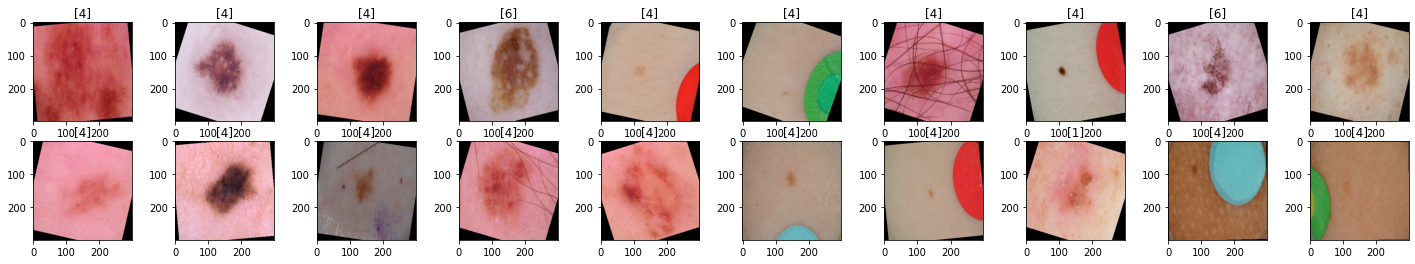

In [232]:
dataiter = iter(training_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

# for inputs, labels in training_loader:
#     for i in range(20):
# #         print(labels[i])
#         plt.imshow(im_convert(inputs[i]))
#     break;

In [233]:
model = models.googlenet(pretrained=True, progress=True)

In [234]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [235]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(1024, 512)),
                                        ('relu', nn.ReLU()),
                                        ('fc2', nn.Linear(512, 10)),
                                        ('output', nn.Softmax(dim=1))]))

model.fc = classifier

In [236]:
model = model.to(device)

In [237]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=0.1, weight_decay=0.9, momentum=0.9, centered=False)

In [238]:
epochs = 30
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  for inputs, labels in tqdm(training_loader):
    inputs = inputs.to(device) #GPU
    labels = labels.to(device) #GPU
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else: 
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device) #GPU
        val_labels = val_labels.to(device) #GPU
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(train_set)*100
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(val_set)*100
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch: ', (e+1))
    print('training loss: {:.4f}, {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

  0%|          | 0/192 [00:00<?, ?it/s]

epoch:  1
training loss: 1.8285, 76.4967 
validation loss: 1.7789, 77.5988 


  0%|          | 0/192 [00:00<?, ?it/s]

epoch:  2
training loss: 1.7723, 77.6784 
validation loss: 1.7722, 77.5988 


  0%|          | 0/192 [00:00<?, ?it/s]

epoch:  3
training loss: 1.7733, 77.6784 
validation loss: 1.7727, 77.5988 


  0%|          | 0/192 [00:00<?, ?it/s]

epoch:  4
training loss: 1.7727, 77.6784 
validation loss: 1.7838, 77.5988 


  0%|          | 0/192 [00:00<?, ?it/s]

epoch:  5
training loss: 1.7733, 77.6784 
validation loss: 1.7737, 77.5988 


 25%|██▌       | 48/192 [06:07<18:23,  7.66s/it]


KeyboardInterrupt: 

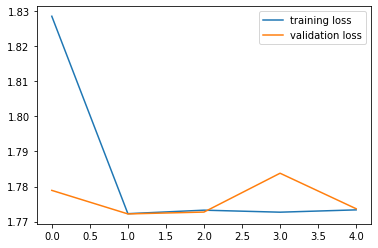

In [239]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()

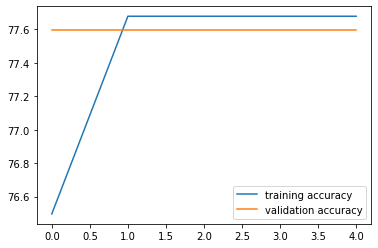

In [240]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()

In [ ]:
# torch.save(model.state_dict(), "./model/melanoma")

  # ... after training, save your model 
# model.save_state_dict('./model/mytraining.pt')

  # .. to load your previously training model:
#   model.load_state_dict(torch.load('./modelmytraining.pt'))
torch.save(model, "./model/googlenet3.pt")

In [207]:
model = torch.load("./model/googlenet2.pt")

In [208]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [215]:
# UnFreeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = True